In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
print(tf.__version__)

2.15.0


# **1. Descargar el dataset y almacenarlo**

Por sencillez, se adjunta un documento csv con las cotizaciones de Google desde el 1 de enero del 2015 al 31 de enero del 2023. La idea es reservar enero del 2023 para la predicción, y el resto para el entrenamiento.

El dataset puede obtenerse de https://finance.yahoo.com/quote/GOOG/history?period1=1420070400&period2=1675123200&interval=1d&filter=history&frequency=1d&includeAdjustedClose=true.

**Es necesario subir el dataset a Google Colab** (o ubicarlo en la dirección apropiada en cualquier otro caso) para tener acceso a él. Una vez subido, lo abrimos para echar un vistazo a los primeros datos para ver cómo está estructurado el dataset:

In [ ]:
dataset = pd.read_csv('GOOG.csv', parse_dates=['Date'])
dataset.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2015-01-02,26.378078,26.490770,26.133251,26.168653,26.168653,28951268
1,2015-01-05,26.091366,26.144720,25.582764,25.623152,25.623152,41196796
2,2015-01-06,25.679497,25.738087,24.983908,25.029282,25.029282,57998800
3,2015-01-07,25.280592,25.292759,24.914099,24.986401,24.986401,41301082
4,2015-01-08,24.831326,25.105074,24.482782,25.065184,25.065184,67071641


Aunque no es necesario entender la terminología bursatil, por simple cúltura se recomienda consultar qué es cada término. En esta actividad nos vamos a centrar en el valor de cierre (Close), que indica el precio de la acción (de Google, en este caso) en el momento de cierre de los mercados, es decir, el valor que tiene la acción al finalizar el día.

Un buen punto de partida puede ser el mostrar graficamente todos los valores de cierre con los que vamos a trabajar:

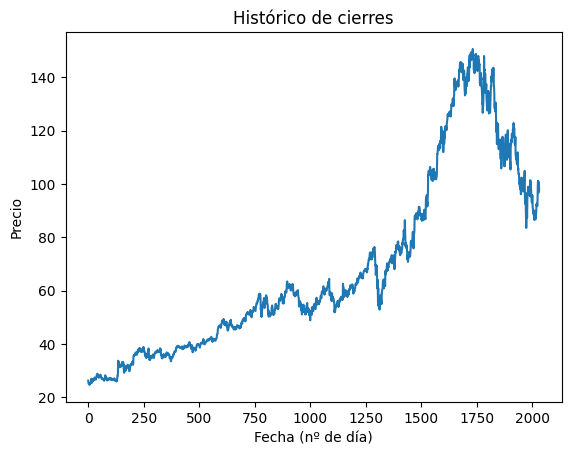

In [ ]:
dataset['Close'].plot()

plt.title('Histórico de cierres')
plt.xlabel('Fecha (nº de día)')
plt.ylabel('Precio')
plt.show()

# 2. Normalización de los datos

Como ya sabemos, una técnica muy común consiste en normalizar los datos en valores entre 0 y 1. Cuando se trata de series temporales, no podemos simplemente dividir por 255 como hacemos habitualmente con los píxeles.

**Paso 1**: Obten los valores mínimos y máximos de la serie. A continuación, utiliza la diferencia entre esos dos valores para normalizar: (original - mínimo) / (máximo - mínimo). Puedes utilizar min y max de numpy para ellos.





In [ ]:
import numpy as np

dataset['Close normalizado'] = (dataset['Close'] - np.min(dataset['Close'])) / (np.max(dataset['Close']) - np.min(dataset['Close']))

Muestra algunos valores para verificar que has normalizado correctamente.




In [ ]:
dataset[['Close', 'Close normalizado']].head()

,Close,Close normalizado
0,26.168653,0.012751
1,25.623152,0.008427
2,25.029282,0.003720
3,24.986401,0.003380
4,25.065184,0.004004


# 3. Preprocesado de los datos

Puesto que estamos trabajando con series temporales, vamos a convertir el vector de entrada en una matriz. En la matriz organizaremos los datos por días, de forma que cada fila contiene D precios de cierre, y una predicción del día diguiente (D+1). Recuerda cómo trabajamos con series temporales:
*   Fila 0: desde el día 0 al día D-1, predice el día D
*   Fila 1: desde el día 1 al día D, predice el día D+1
*   Fila 2: desde el día 2 al día D+1, predice el día D+2
*   Fila 3: desde el día 3 al día D+2, predice el día D+3
*   etc

**Paso 2**: realiza las siguientes acciones como preparativo a tu modelo:

1.   Asigna un valor de 50 a D.
2.   Crea la matriz explicada anteriormente. Por sencillez, se recomienda crear una matriz de D elementos por fila (en lugar de D+1 como se ha explicado) y un vector con las predicciones.
3.   Muestra la estructura o estructuras creadas.




In [ ]:
D = 50
normalizados = dataset['Close normalizado'].values

X = []
Y = []
for i in range (D, len(normalizados)):
  X.append(normalizados[i-D:i])
  Y.append(normalizados[i])

X = np.array(X)
X = np.expand_dims(X, axis = 2)
Y = np.array(Y)

print(f'Tamaño del conjunto de datos de entrada: {X.shape}')
print(f'Tamaño del conjunto de etiquetas: {Y.shape}')

Tamaño del conjunto de datos de entrada: (1983, 50, 1)
Tamaño del conjunto de etiquetas: (1983,)


# 4. Conjuntos de entrenamiento y de prueba

**Paso 3**: Crear las variables **x_train, y_train, x_test e y_test**. Recuerda que utilizamos el último mes (enero del 2023) para test y el resto para entrenamiento.

In [ ]:
x_train, x_test = X[:-31], X[-31:]
y_train, y_test = Y[:-31], Y[-31:]

# 5. Creación del modelo

**Paso 4**: Construye una red neuronal recurrente para trabajar con los datos anteriores. Para ellos debes:
*   Utilizar una capa LSTM. Debes encontrar su configuración adecuada.
*   Utilizar una capa final densa de una sola neurona.



In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential()
model.add(layers.LSTM(units=128, input_shape=(X.shape[1], X.shape[2])))
model.add(layers.Dense(1))

**Paso 5:** Muestra la estructura de tu modelo con summary():



In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               66560     
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 66689 (260.50 KB)
Trainable params: 66689 (260.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


# 6. Compilación y entrenamiento

**Paso 6:** Compila tu modelo. Debes probar diferentes optimizadores y funciones de pérdida para encontrar la combinación más adecuada.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error')

**Paso 7:** Utiliza fit() para entrenar el modelo. Elige los valores adecuados de batch y de épocas.

In [ ]:
model.fit(x_train, y_train, batch_size=32, epochs=50, verbose=2)

Epoch 1/50
61/61 - 5s - loss: 0.0132 - 5s/epoch - 74ms/step
Epoch 2/50
61/61 - 3s - loss: 4.9022e-04 - 3s/epoch - 53ms/step
Epoch 3/50
61/61 - 4s - loss: 4.8820e-04 - 4s/epoch - 58ms/step
Epoch 4/50
61/61 - 2s - loss: 4.5636e-04 - 2s/epoch - 41ms/step
Epoch 5/50
61/61 - 3s - loss: 4.6909e-04 - 3s/epoch - 42ms/step
Epoch 6/50
61/61 - 2s - loss: 4.3672e-04 - 2s/epoch - 41ms/step
Epoch 7/50
61/61 - 4s - loss: 4.4946e-04 - 4s/epoch - 66ms/step
Epoch 8/50
61/61 - 3s - loss: 4.2792e-04 - 3s/epoch - 45ms/step
Epoch 9/50
61/61 - 3s - loss: 4.2138e-04 - 3s/epoch - 43ms/step
Epoch 10/50
61/61 - 3s - loss: 3.8765e-04 - 3s/epoch - 47ms/step
Epoch 11/50
61/61 - 7s - loss: 3.8964e-04 - 7s/epoch - 107ms/step
Epoch 12/50
61/61 - 3s - loss: 3.9728e-04 - 3s/epoch - 55ms/step
Epoch 13/50
61/61 - 3s - loss: 3.5790e-04 - 3s/epoch - 55ms/step
Epoch 14/50
61/61 - 3s - loss: 3.6812e-04 - 3s/epoch - 42ms/step
Epoch 15/50
61/61 - 4s - loss: 3.4847e-04 - 4s/epoch - 68ms/step
Epoch 16/50
61/61 - 2s - loss: 3.5921

# 7. Predicción

Mide la calidad de tu modelo analizando las predicciones que es capaz de hacer en relación al conjunto de test.

**Paso 8:** Utiliza predict() para obtener las mediciones con el conjunto de prueba.

In [ ]:
y_pred = model.predict(x_test)

1/1 [==============================] - 2s 2s/step


**Paso 9**: Realiza un gráfica comparativa entre las predicciones y los valores reales.

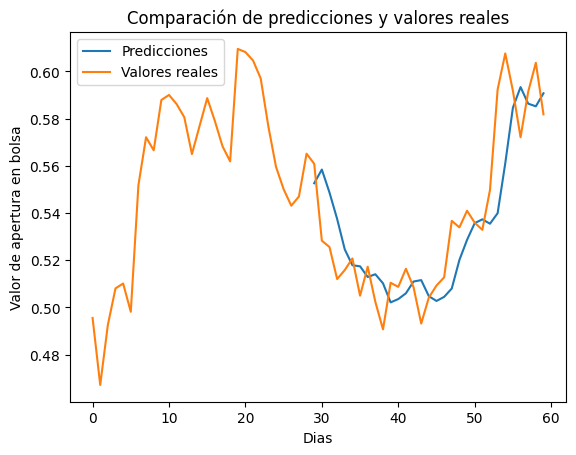

In [ ]:
plt.plot(range(29, 60), y_pred.flatten(), label='Predicciones')
plt.plot(range(60), Y[-60:], label='Valores reales')
plt.xlabel('Dias')
plt.ylabel('Valor de apertura en bolsa')
plt.title('Comparación de predicciones y valores reales')
plt.legend()
plt.show()